<a href="https://colab.research.google.com/github/LM1997610/NN/blob/main/NNDS_2023_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks for Data Science Applications
## Homework 1: Saliency maps for interpretability

**Name**: *\<insert your name here\>*

**Matricola**: *\<insert your ID here\>*

> ✍ Upload the completed notebook **before 17/11/2023 at 23:59** on the Google Classroom page.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

In [3]:
! git clone https://github.com/LM1997610/NN

fatal: destination path 'NN' already exists and is not an empty directory.


### Overview

Neural networks are powerful tools, but they are **black-boxes**, meaning that it is difficult to provide human-understandable explanations on what they are doing. The field of **explanaibility** is concerned with finding algorithms for achieving this. In this homework, you will be guided in implementing some basic explanaibility algorithms (**saliency maps**), which is an instructive way of playing with the TensorFlow autodiff framework.

### Instructions

1. The homework is divided into four mandatory exercises (**5 points in total**), and a few optional exercises. Optional exercises are provided if you like the topic and would like to explore more; you are free to ignore them or complete as many as you want. I will not grade them but I might provide feedback for especially nice solutions.
2. Completing the homework successfully will remove 1 exercise from the end-of-term homework.
3. If your grade does not satisfy you, you are also free to complete the full EoT homework to recover it.
3. The grade can be kept for the entire academic year (up to October 2024).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: the homework must be done _fully in TensorFlow_ and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

## Warmup: Data loading

For this homework, you can select any **tabular dataset** that you like, for either classification or regression. A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. The choice of dataset will not influence the mark.

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

In [4]:
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from NN.Untitled import do_plot, show_images

In [5]:
# TODO: Insert any data loading code here.
# If the data loading part is complex, consider using a separate .py file that you can attach to the submission.

(train_data, val_data, test_data), data_info = tfds.load("cifar10",
                                                        split=["train[0:97%]", "train[97%:]", "test"],
                                                        batch_size = 300,
                                                        as_supervised=True,
                                                        with_info = True,
                                                        shuffle_files = True)

#train_data, val_data, test_data = tfds.load("stl10",
#                                            split=["test", "train[0:55%]", "train[55%:]"],
#                                            as_supervised=True, batch_size = 25,
#                                            shuffle_files = True)

def preproccess(image, label):
  image = tf.cast(image, tf.float32)/ 255.0
  return image, label

train_data = train_data.map(lambda image, label: preproccess(image, label))
val_data = val_data.map(lambda image, label: preproccess(image, label))
test_data = test_data.map(lambda image, label: preproccess(image, label))

# X, y = ...

In [6]:
sum(1 for i in train_data)

162

### Exercise 1: Train a neural network model (1 point)

Define, train, and test a neural network for the provided dataset.

☝ You are free to make any modelling choice (e.g., activation function, normalization layers, etc.), provided the result makes sense.

✅ **Completion requirement**: print on screen the test accuracy of the network. Additional comments and visualizations are also appreciated.

In [7]:
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [8]:
def add_conv_block(model, n_filters):

  model.add(tf.keras.layers.Conv2D(filters = n_filters,                 # conv_layer
                                kernel_size = (3, 3),
                                padding = "same"))

  model.add(tf.keras.layers.BatchNormalization())                       # batch_normalization
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))  # pool_layer
  model.add(tf.keras.layers.Activation('relu'))                         # activation
  model.add(tf.keras.layers.Dropout(0.3))                               # drop_out

  return model

In [9]:
# TODO: define a suitable neural network.

hidden_layers =  [128, 256, 512, 512, 512]

model = tf.keras.Sequential()

# model.add(tf.keras.layers.InputLayer(input_shape=(96,96,3 )))

for i in hidden_layers:
  model = add_conv_block(model, i)

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
#model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(10))

In [10]:
# TODO: train the neural network.

lr = 0.001
weight_decay = 0.0001
milestones = [8, 13, 17]
gamma = 0.5
n_epoches = 21

cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
optimizer = tf.keras.optimizers.Adam(learning_rate = lr, weight_decay = weight_decay)

def scheduler(epoch, lr):
    if epoch in milestones:
        lr *= gamma
    return lr

call= [tf.keras.callbacks.TerminateOnNaN(),
      tf.keras.callbacks.LearningRateScheduler(scheduler),
      tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1)]

model.compile(optimizer= optimizer, loss = cross_entropy, metrics = accuracy)

history = model.fit(train_data, epochs=n_epoches, validation_data = val_data, callbacks = call, verbose=1)

Epoch 1/21
162/162 [==============================] - 33s 119ms/step - loss: 1.5752 - sparse_categorical_accuracy: 0.4251 - val_loss: 3.3197 - val_sparse_categorical_accuracy: 0.0933 - lr: 0.0010
Epoch 2/21
162/162 [==============================] - 16s 101ms/step - loss: 1.0800 - sparse_categorical_accuracy: 0.6095 - val_loss: 2.5528 - val_sparse_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/21
162/162 [==============================] - 16s 101ms/step - loss: 0.8833 - sparse_categorical_accuracy: 0.6858 - val_loss: 2.1043 - val_sparse_categorical_accuracy: 0.3307 - lr: 0.0010
Epoch 4/21
162/162 [==============================] - 16s 101ms/step - loss: 0.7676 - sparse_categorical_accuracy: 0.7307 - val_loss: 1.3919 - val_sparse_categorical_accuracy: 0.5247 - lr: 0.0010
Epoch 5/21
162/162 [==============================] - 16s 101ms/step - loss: 0.6851 - sparse_categorical_accuracy: 0.7578 - val_loss: 0.9192 - val_sparse_categorical_accuracy: 0.6740 - lr: 0.0010
Epoch 6/21
162/162 [


34/34 [==============================] - 1s 31ms/step - loss: 0.4733 - sparse_categorical_accuracy: 0.8554


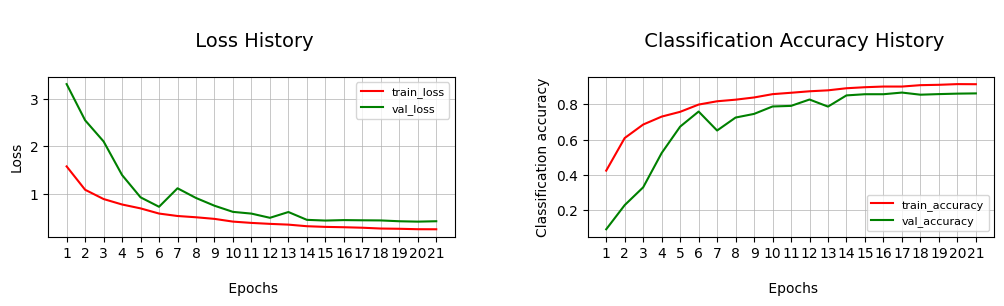

In [12]:
# TODO: test the neural network and print the result on screen.

print()
test_loss, test_acc = model.evaluate(test_data, verbose=1)

do_plot(history, 21)

### Exercise 2: Computing a vanilla saliency map (1 points)

> Before starting, I suggest you read [1] as a warm-up. This is one of the first papers that tried to apply this kind of techniques to modern neural networks.

What do we mean by explainability? Consider the neural network $f(\cdot)$ you just trained, and a prediction $\hat{y} = f(x)$ we want to analyze. **Feature attribution** methods try to assign a weight $w_i$ to each input feature $x_i$, to understand which parts of the input have contributed the most to the explanation.

The simplest feature attribution technique, called **vanilla saliency map**, simply computes the gradient at that point:

$$
  S(x) = \left\lvert \frac{\partial f_c(x)}{\partial x} \right\rvert
$$

where  $c$ is the index corresponding to the predicted class.

✅ **Completion requirement**: Take any point from your test dataset, and compute a saliency map using `tf.GradientTape`. Check the weight to see if you can find anything to "interpret". **Note**: I am not evaluating how nice / good the explanation is, only the code.

In [13]:
# TODO: Take an element from your test set and compute the saliency map

test_images, test_labels = zip(*[(image, label) for image, label in test_data])
test_images, test_labels = test_images[0], test_labels[0]

def silency_map(index):

  with tf.GradientTape() as tape:

    #tensor_input = tf.convert_to_tensor(np.expand_dims(image, axis=0))
    tensor_input = tf.expand_dims(test_images[index], axis=0)
    tape.watch(tensor_input)

    class_scores = model(tensor_input, training=False)
    predicted_class = np.argmax(class_scores)

    class_channel = class_scores[:,predicted_class]

  grads = tape.gradient(class_channel, tensor_input)

  dgrad_abs = tf.math.abs(grads)
  dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

  ## normalize to range between 0 and 1
  arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
  map = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

  return map, grads

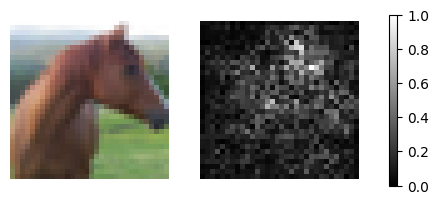

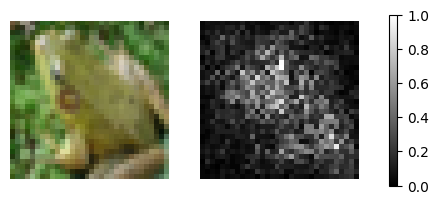

In [14]:
# TODO: Check the saliency map to analyze the result. What can you say about the map?

index = 6
mappa, grad = silency_map(index)
show_images(test_images[index], mappa, smooth_map=None)

index = 2
mappa, grad = silency_map(index)
show_images(test_images[index], mappa,smooth_map=None)

### Exercise 3: Advanced saliency maps (1 point)

> For this exercise, you can read [2] for an overview on the limits of vanilla saliency maps and a description of SmoothGrad.

Saliency maps have several issues: most notably, they suffer from noise and they are not stable to small changes in the input or in the model (try running again the training and interpreting the same point). Many methods have been proposed to overcome this.

**[SmoothGrad](https://arxiv.org/abs/1706.03825)**, for example, computes multiple saliency maps from noisy versions of the input:

$$
  \text{SmoothGrad}(x) = \frac{1}{n}\sum_{i=1}^n S(x + \varepsilon_i), \;\; \varepsilon_i \sim \mathcal{N}(0, \sigma^2I)
$$

where $\varepsilon$ is a vector of the same shape as $x$, whose values are sampled from a normal distribution with zero mean and small variance.

🟩 **Completion requirement**: Implement the SmoothGrad procedure for the same point. Has the explanation improved? Bonus points if you can avoid running a for-loop, and by calling the gradient operation a single time.


In [32]:
def SmoothGrad_x2(index, N = 150, var = 0.015):

  e = tf.random.normal(shape=(N, 32, 32, 3), mean=0.0, stddev=tf.sqrt(var))

  with tf.GradientTape() as tape:

    tensor_input = test_images[index] + e
    tape.watch(tensor_input)

    class_scores = model(tensor_input, training=False)
    predicted_class = np.argmax(class_scores, axis =1)

    # Use tf.stack to create 2D indices for indexing
    indices_2d = tf.stack([tf.range(N), predicted_class], axis=-1)

    # Use tf.gather_nd to extract values
    class_channel = tf.gather_nd(class_scores, indices_2d)

  grads = tape.gradient(class_channel, tensor_input)
  mean_tensor = tf.reduce_mean(grads, axis=0)

  dgrad_abs = tf.math.abs(mean_tensor)
  dgrad_max_ = np.max(dgrad_abs, axis=2)

  ## normalize to range between 0 and 1
  arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
  map = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

  return map

In [33]:
def show_images(immagine, vanilla_map, smooth_map):

  #mappa, g = silency_map(test_images[indx], model)

  if smooth_map is not None:

    fig, ax = plt.subplots(1, 3, figsize=(5, 5))
    a = ax[2].imshow(smooth_map, cmap="gray")
    ax[2].axis('off')

  else:
    fig, ax = plt.subplots(1, 2, figsize=(5, 5))

  ax[0].imshow(immagine)
  ax[0].axis('off')

  a = ax[1].imshow(vanilla_map, cmap="gray")
  ax[1].axis('off')


  plt.colorbar(a, ax = ax, fraction=0.022, pad=0.08)
  plt.show()

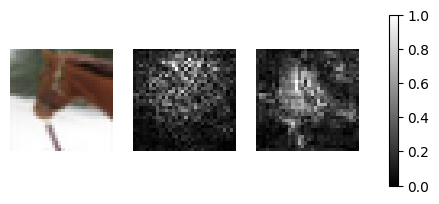

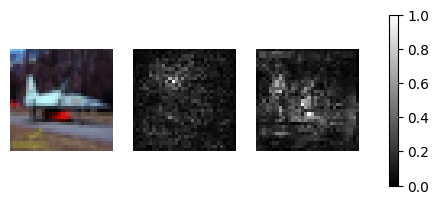

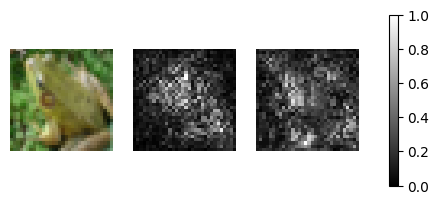

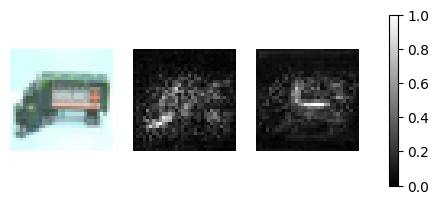

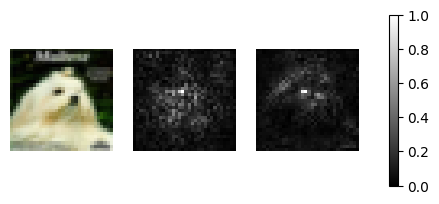

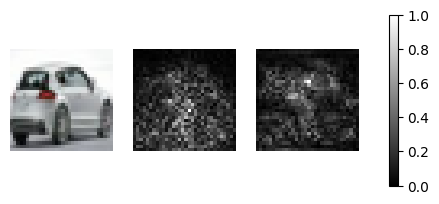

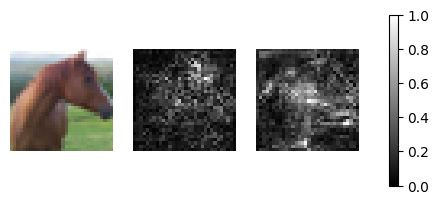

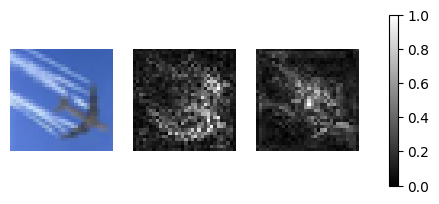

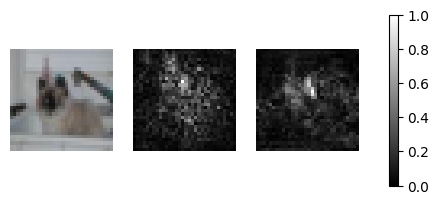

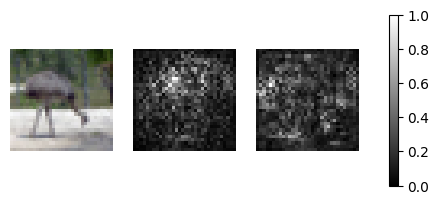

In [34]:
for i in range(10):

  mappa, grad = silency_map(i)
  show_images(test_images[i], mappa, smooth_map=SmoothGrad_x2(i))

### Exercise 4: Global explanations (2 points)

The previous exercises are examples of **local** explanations, where we try to interpret a single prediction of the network. Sometimes we are interested in **global** explanations, that try to find common patterns of behaviour. Suppose we have a dataset $\mathcal{T} = \left\{x_i\right\}$ of examples, we can compute some approximate global measure of influence by averaging their saliency:

$$
\text{GlobalSaliency} = \frac{1}{n} \sum_i S(x_i)
$$

To make this exercise more interesting, we will split it into 3 parts.

**Exercise 4.1**: write a function to compute in parallel the saliency for multiple examples. Note that the resulting matrix $S$ will have shape $(n, d)$, where $n$ is the number of examples and $d$ the size of the input, which is the Jacobian of the network. Try to write the function by avoiding for-loops and multiple tapes, using the [proper tools from TensorFlow](https://www.tensorflow.org/guide/advanced_autodiff).

In [ ]:
# TODO: Write the required function, possibly avoding for-loops.

**Exercise 4.2**: write a function to compute the global saliency and try to explain the results.

In [ ]:
# TODO: Write the required function.

**Exercise 4.3**: note that a linear model $f(x) = w^\top x + b$ is an example of an *intrinsically* interpretable  model, since the weights $w$ can be checked to analyze the global saliency of each feature (see [3]).

In [ ]:
# TODO: Compare the results you obtained before with a simpler linear model.

### Optional exercises and parting words

> ⚠ Explainability is a complex topic, with multiple issues arising from the over-abundance of techniques, their instability, etc. While an interesting research topic to pursue, never use blindly these techniques in high-stake applications!

These exercises were just a brief and short introduction to the topic of explainability. Below you can find some additional exercises to tackle if you are interested. Remember that these are not part of your grade, but I am happy to provide feedback if they are of interest to you.

1. There are dozens of possible variations on feature attribution methods, which may or may not provide better results (see [4] for a benchmarking and this nice [Distill blog post](https://distill.pub/2020/attribution-baselines/)). **[Integrated Gradients](https://arxiv.org/abs/1703.01365)** are an interesting example, where the saliency is integrated over a path ranging from an empty input to the true input. Try implementing integrated gradients.
2. **Data attribution** methods are a different class of explanation methods, which try to predict what points in the dataset where most influential to a given prediction (e.g., a picture of a cat will be especially influential on similar pictures). One example of such methods is TracIn [5], which stores checkpoints of the model during training and evaluates the correlation of the gradients. Try to implement TracIn or any other metric of data influence.
3. A recent line of research tries to use large language models (e.g., ChatGPT) to explain other models (e.g., see [Language models can explain neurons in language models](https://openai.com/research/language-models-can-explain-neurons-in-language-models)). If you have access to an LLM, you can try it! Take a specific neuron in the model, and collect the activation for multiple examples. Provide these activations to the LLM, and prompt it to provide a human-understandable explanation. What is the result?

### Final checklist

1. Carefully check all code. Insert comments when needed. Search for "TODO" to see if you forgot something.
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Upload the completed notebook **before 17/11/2023 23:59** on the Google Classrom page.

### Bibliography

[1] Simonyan, K., Vedaldi, A. and Zisserman, A., 2013. [Deep inside convolutional networks: Visualising image classification models and saliency maps](https://arxiv.org/abs/1312.6034). arXiv preprint arXiv:1312.6034.

[2] Smilkov, D., Thorat, N., Kim, B., Viégas, F. and Wattenberg, M., 2017. [SmoothGrad: removing noise by adding noise](https://arxiv.org/abs/1706.03825). arXiv preprint arXiv:1706.03825.

[3] Rudin, C., 2019. [Stop explaining black box machine learning models for high stakes decisions and use interpretable models instead](https://www.nature.com/articles/s42256-019-0048-x). Nature Machine Intelligence, 1(5), pp. 206-215.

[4] Nguyen, G., Kim, D. and Nguyen, A., 2021. [The effectiveness of feature attribution methods and its correlation with automatic evaluation scores](https://proceedings.neurips.cc/paper/2021/hash/de043a5e421240eb846da8effe472ff1-Abstract.html). Advances in Neural Information Processing Systems, 34, pp.26422-26436.

[5] Pruthi, G., Liu, F., Kale, S. and Sundararajan, M., 2020. [Estimating training data influence by tracing gradient descent](https://proceedings.neurips.cc/paper/2020/hash/e6385d39ec9394f2f3a354d9d2b88eec-Abstract.html). Advances in Neural Information Processing Systems, 33, pp. 19920-19930.